# Benchmark Robitaille model grid against a well-sampled & tested SED

We're using the SED from https://ui.adsabs.harvard.edu/abs/2021A%26A...646A..18Z / https://www.aanda.org/articles/aa/abs/2021/02/aa39536-20/aa39536-20.html as our test case.



In [1]:
cd  /blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/

/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/notebooks


In [3]:
import imp, table_loading
imp.reload(table_loading)

<module 'table_loading' from '/blue/adamginsburg/adamginsburg/SPICY_ALMAIMF/table_loading.py'>

In [4]:
from table_loading import *

In [6]:
tbl = Table.read('SPICY_withAddOns.fits')

In [7]:
# wavelength, flux, eflux, aperture
data = [
    [0.9, 0.062, 0.019, 24],
    [1.25, 2.2, 0.2, 12],
    [1.65, 8.2, 0.8, 12],
    [2.20, 17.1, 1.7, 12],
    [3.6, 18.3, 0.8, 12],
    [4.5, 17.0, 0.8, 12],
    [4.6, 17.96, 0.5, 12],
    [5.8, 12.5, 0.7, 12],
    [8.0, 6.8, 0.5, 12],
    [11.6, 4.5, 0.5, 8],
    [24, 160.6, 16.0, 30],
    [65, 4398, 274, 90],
    [70, 5555, 1000, 120],
    [100, 11000, 3000, 125],
    [160, 19000, 4000, 80],
    [250, 23700, 5000, 90],
    [350, 15000, 3000, 90],
    [450, 6700, 2500, 60],
    [500, 6200, 2000, 90],
    [850, 1000, 300, 60],
    [1110, 238, 45, 5],
    [1300, 120, 30, 5],
    [2900, 14.5, 3.0, 5],
    [8100, 1.10, 0.15, 5],
    [10300, 0.65, 0.1, 5],
    [40000, 0.05, 0.01, 5],
    [64000, 0.047, 0.02, 5],
]

A screenshot of the table, so we can cross-check with the transcribed data above:

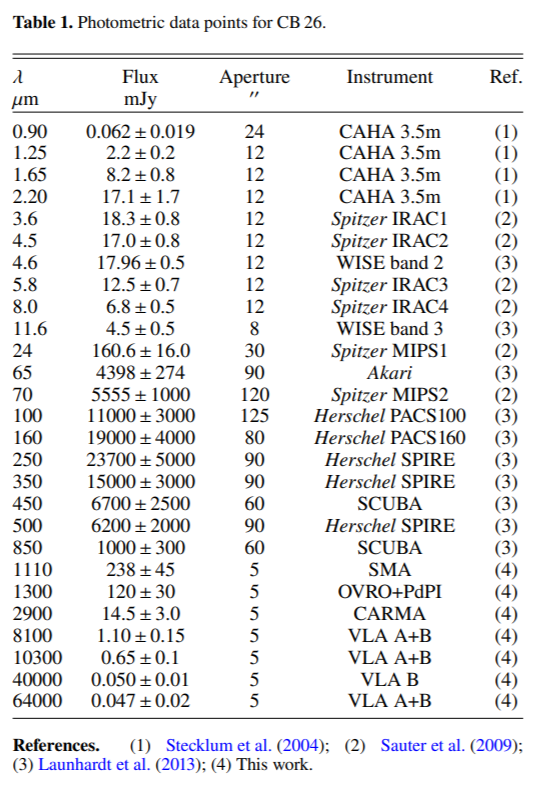

In [8]:
from IPython.display import Image

Image('sed.png')

In [9]:
cb26tbl = Table(rows=data,
                names=['wavelength', 'flux', 'eflux', 'aperture'],
                units=(u.um, u.mJy, u.mJy, u.arcsec)
               )
cb26tbl

wavelength,flux,eflux,aperture
um,mJy,mJy,arcsec
float64,float64,float64,int64
0.9,0.062,0.019,24
1.25,2.2,0.2,12
1.65,8.2,0.8,12
2.2,17.1,1.7,12
3.6,18.3,0.8,12
4.5,17.0,0.8,12
4.6,17.96,0.5,12
5.8,12.5,0.7,12


In [10]:
cb26tbl['aperture'].quantity

<Quantity [ 24,  12,  12,  12,  12,  12,  12,  12,  12,   8,  30,  90, 120,
           125,  80,  90,  90,  60,  90,  60,   5,   5,   5,   5,   5,   5,
             5] arcsec>

In [11]:
fits = {geom:
        fit_a_source(data=cb26tbl['flux'],#.quantity,
             error=cb26tbl['eflux'],#.quantity,
             valid=np.ones(len(cb26tbl)), aperture_size=cb26tbl['aperture'].quantity,
             filters=cb26tbl['wavelength'].quantity,
                   av_range=[1,30],
                   distance_range=[110,170]*u.pc,
                     geometry=geom,
                  )
        for geom in geometries}

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---s-i
   Log[d] stepping     :  0.02
   Number of distances :  11

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading fluxes at 0.9 um


   Reading fluxes at 1.25 um
   Reading fluxes at 1.65 um
   Reading fluxes at 2.2 um
   Reading fluxes at 3.6 um
   Reading fluxes at 4.5 um
   Reading fluxes at 4.6 um
   Reading fluxes at 5.8 um
   Reading fluxes at 8.0 um
   Reading fluxes at 11.6 um
   Reading fluxes at 24.0 um
   Reading fluxes at 65.0 um
   Reading fluxes at 70.0 um
   Reading fluxes at 100.0 um
   Reading fluxes at 160.0 um
   Reading fluxes at 250.0 um
   Reading fluxes at 350.0 um
   Reading fluxes at 450.0 um
   Reading fluxes at 500.0 um
   Reading fluxes at 850.0 um
   Reading fluxes at 1110.0 um
   Reading fluxes at 1300.0 um
   Reading fluxes at 2900.0 um
   Reading fluxes at 8100.0 um
   Reading fluxes at 10300.0 um
   Reading fluxes at 40000.0 um
   Reading fluxes at 64000.0 um
 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  s---smi
   Log[d] stepping     :  0.02
   Number of dis

In [12]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 16

In [13]:
pl.style.use('dark_background')

In [14]:
%run plot_fit.py

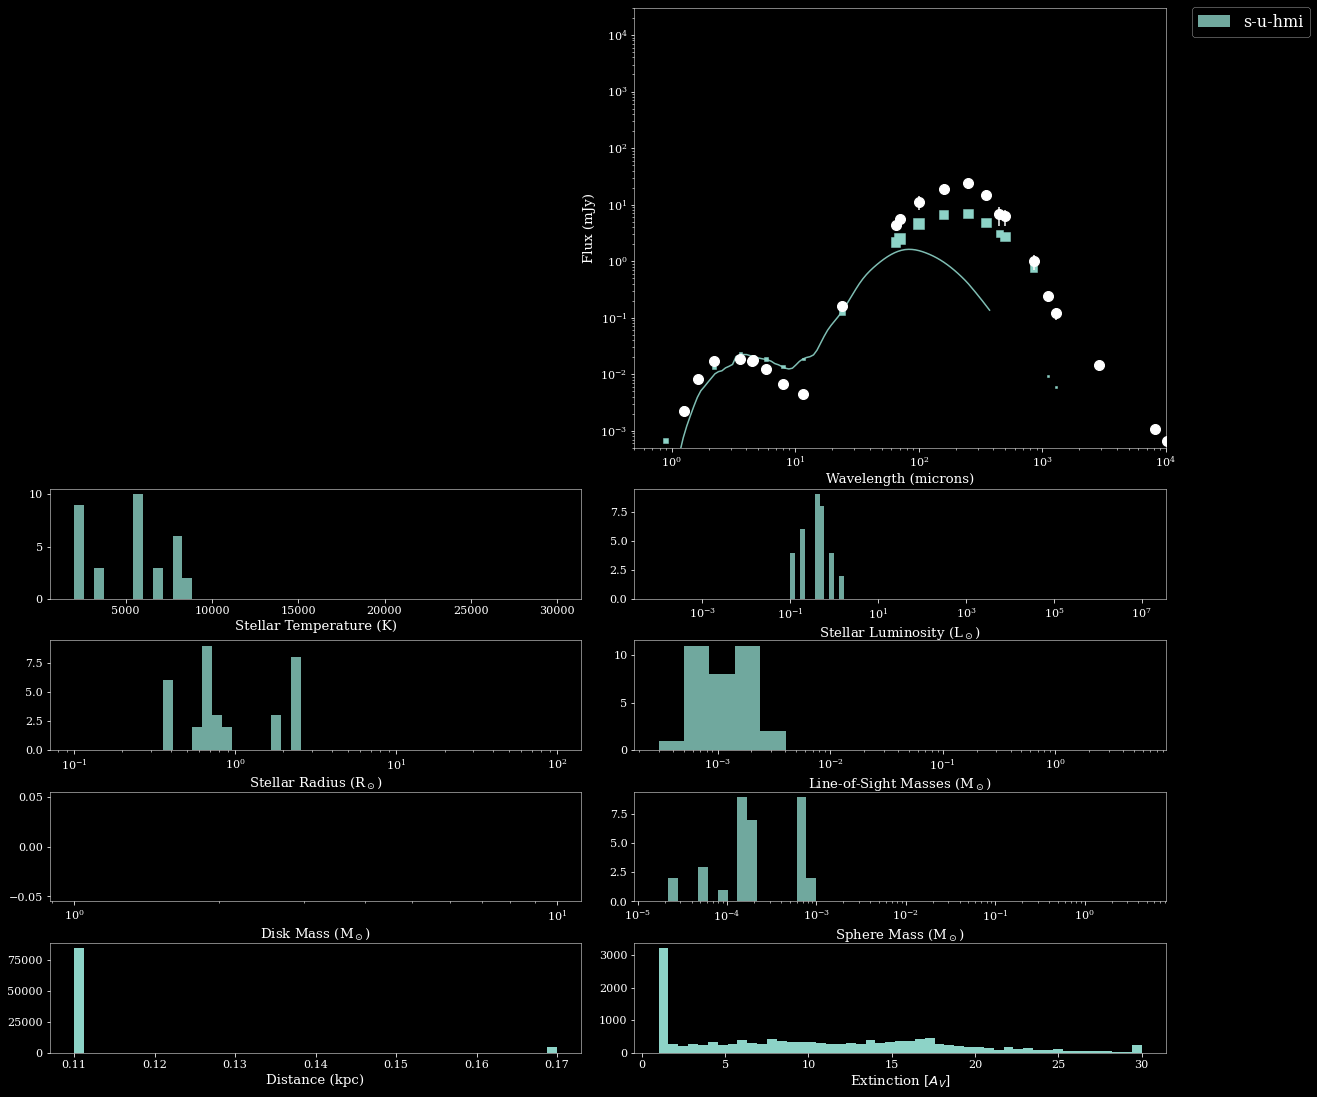

In [15]:
fit = fits['s-u-hmi']
plot_fit({'s-u-hmi': fit}, ['s-u-hmi'], chi2limit=1000,)

In [16]:
okgeo = []
for geom in geometries:
    # we impose an _absolute_ chi^2 limit (the fitter uses a _relative_, delta chi2 limit)
    print(f"{geom}: {np.nanmin(fits[geom].chi2):12.1f}")
    if np.nanmin(fits[geom].chi2) < 1000:
        okgeo.append(geom)

s---s-i:      54392.9
s---smi:      27900.3
sp--s-i:        734.1
sp--h-i:       1021.7
s---smi:      27900.3
s-p-smi:       9900.4
s-p-hmi:       2687.5
s-pbsmi:        658.9
s-pbhmi:        893.8
s-u-smi:       2063.6
s-u-hmi:       2068.1
s-ubsmi:       1687.1
spu-smi:        996.2
spu-hmi:        900.8
spubsmi:        820.5
spubhmi:        471.9


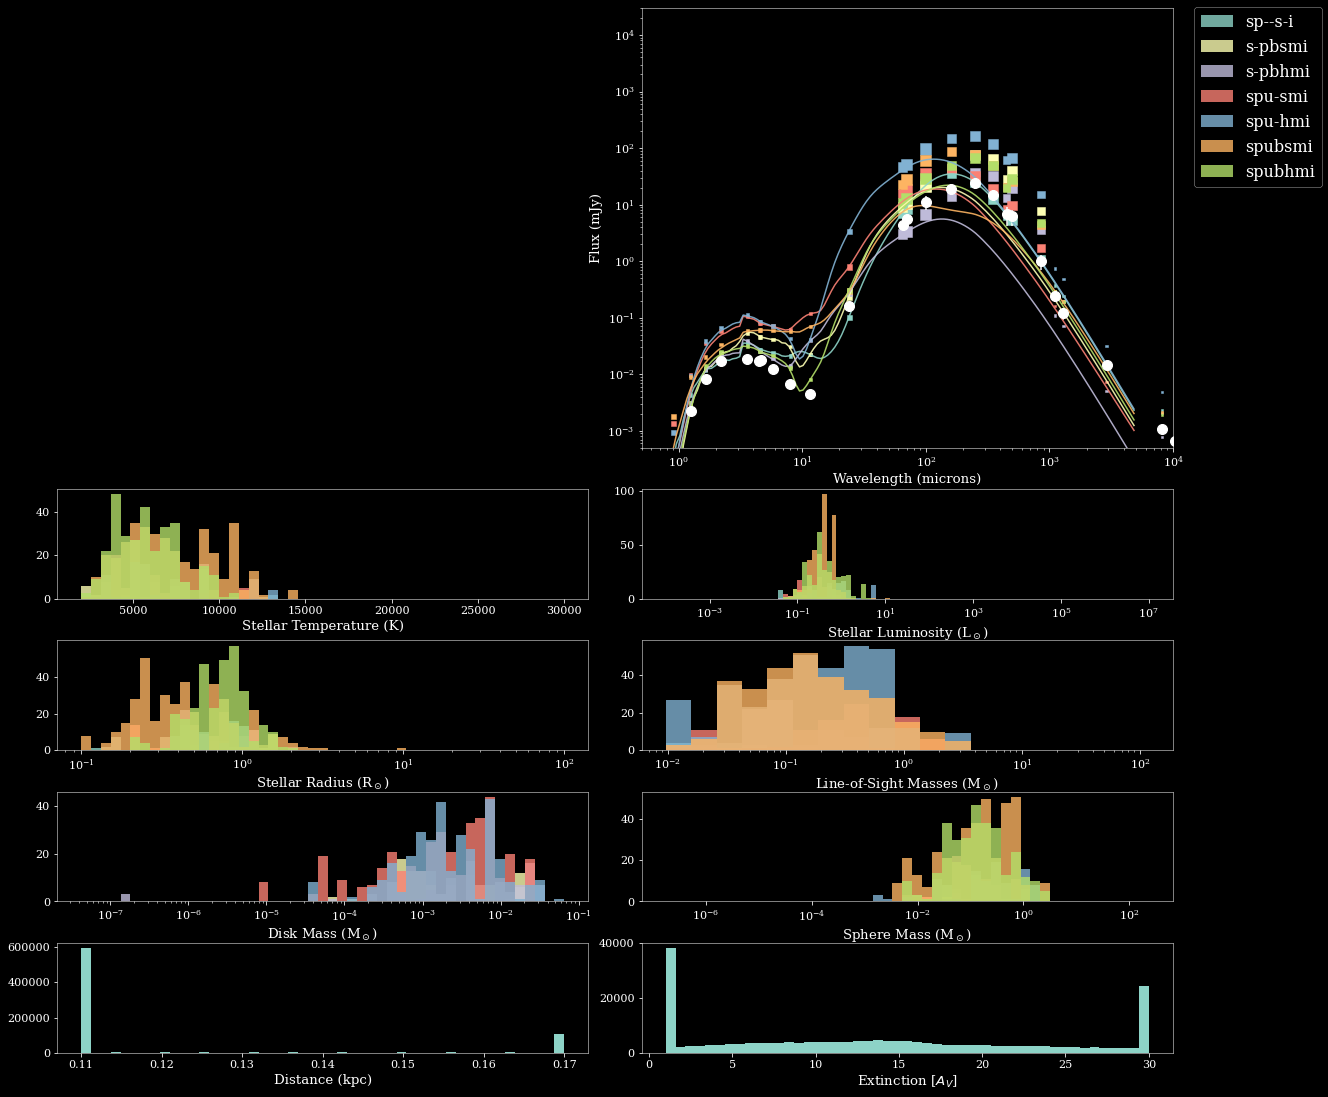

In [17]:
plot_fit(fits, okgeo, chi2limit=1000,)

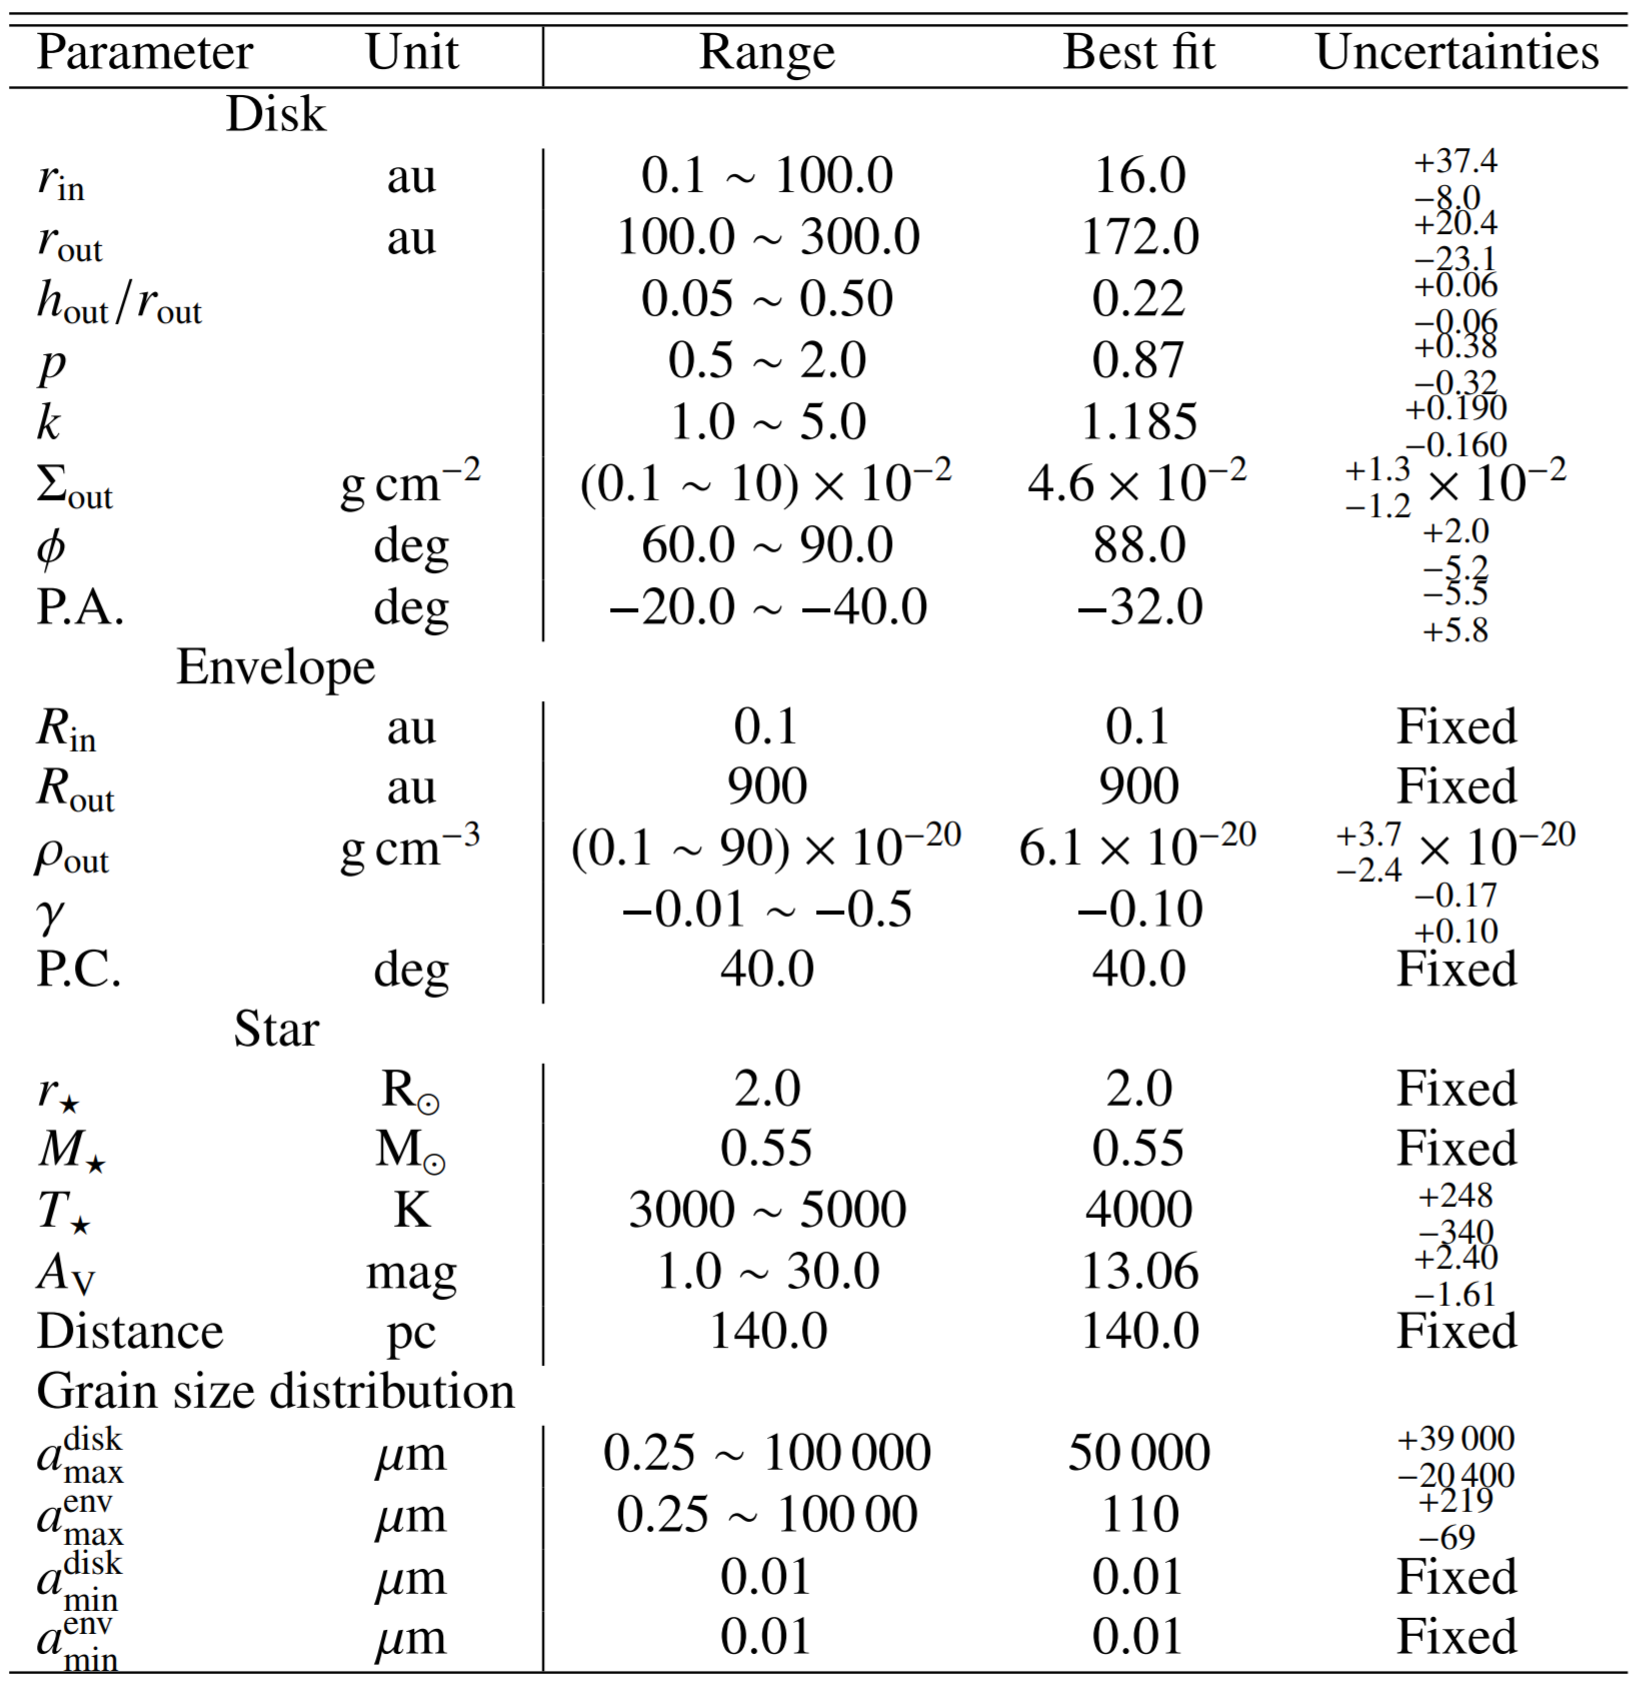

In [40]:
Image('fitpars.png', width=600)

The Robitaille models favor smaller, hotter stars - but similar-ish luminosities.

In [19]:
from astropy import constants

In [20]:
L_rob = 0.2 *u.L_sun
L_paper = ((4000*u.K)**4 * 4*np.pi*(2*u.R_sun)**2 * constants.sigma_sb).to(u.L_sun)
print(f"Robitaille: {L_rob:0.1f}, Paper: {L_paper:0.1f}, ratio rob/paper: {L_rob/L_paper:0.2f}")

Robitaille: 0.2 solLum, Paper: 0.9 solLum, ratio rob/paper: 0.22


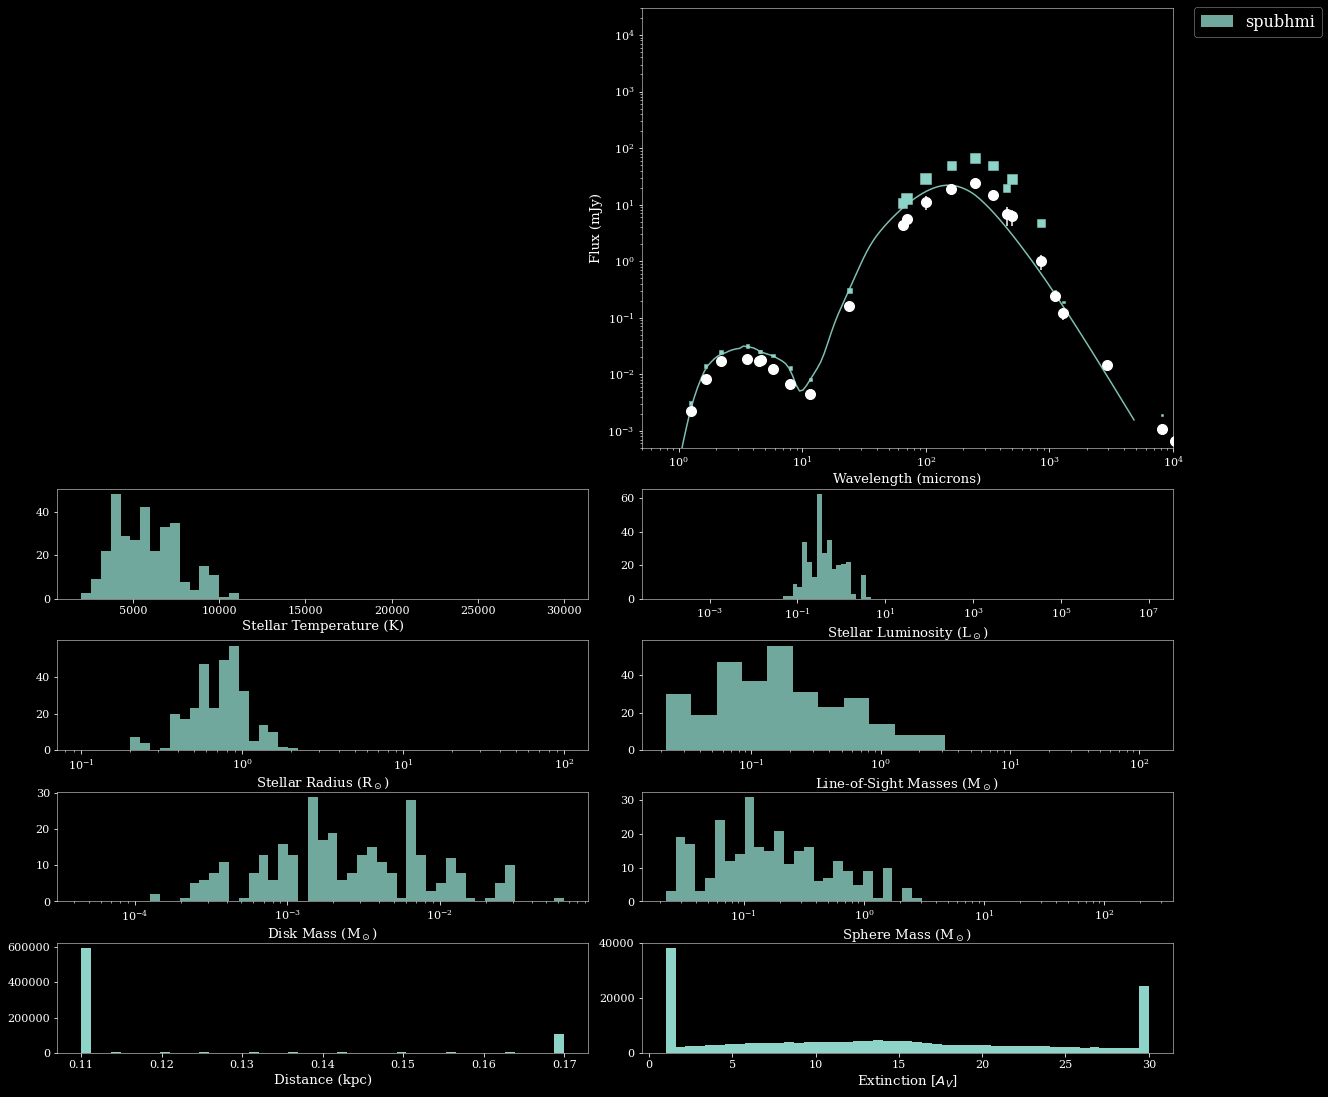

In [21]:
plot_fit(fits, ['spubhmi'], chi2limit=1000,)

# Look at A_V and distance vs. chi^2

The above plots tell us that:

1. Most models are "pegged" to the near near/far distance and the min/max A_V.  Models at these extremes are probably not useful (though the distance doesn't matter so much in this case).
2. There seems to be a preferred A_V of ~15 (close to the ~13 from the paper).

In [75]:
geom = 'spubhmi'
chi2limit=1000
pars, data = datafunction(geom, chi2limit, fits)
fit = fits[geom]

(0.0, 5000.0)

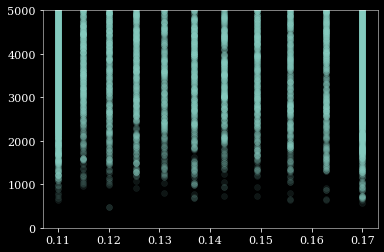

In [76]:
pl.scatter(10**fit.sc, fit.chi2, alpha=0.1)
pl.ylim(0,5000)

(0.0, 5000.0)

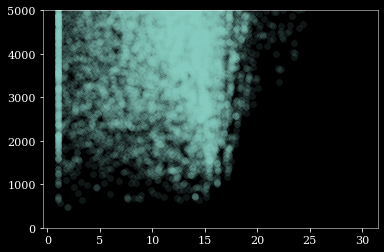

In [77]:
pl.scatter(fit.av, fit.chi2, alpha=0.1)
pl.ylim(0,5000)

This is a sanity check to show that the fit is significantly limiting the mass:

[]

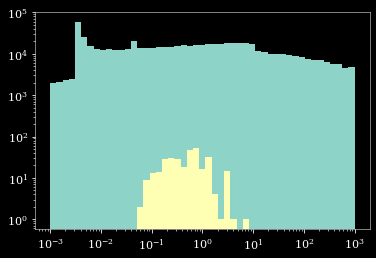

In [78]:
bins = np.logspace(-3,3)
pl.hist(pars['Sphere Masses'][:,9], bins=bins)
pl.hist(data['Sphere Masses'][:,9], bins=bins)

pl.loglog()

In [79]:
# need to check aperture sizes
robitaille_modeldir='/blue/adamginsburg/richardson.t/research/flux/robitaille_models/'
model_dir = f'{robitaille_modeldir}/{geom}'
sedcube = SEDCube.read(f"{model_dir}/flux.fits",)
sedcube.apertures

<Quantity [1.00000000e+02, 1.62377674e+02, 2.63665090e+02, 4.28133240e+02,
           6.95192796e+02, 1.12883789e+03, 1.83298071e+03, 2.97635144e+03,
           4.83293024e+03, 7.84759970e+03, 1.27427499e+04, 2.06913808e+04,
           3.35981829e+04, 5.45559478e+04, 8.85866790e+04, 1.43844989e+05,
           2.33572147e+05, 3.79269019e+05, 6.15848211e+05, 1.00000000e+06] AU>

In [81]:
sedcube.apertures[5], sedcube.apertures[9]

(<Quantity 1128.83789168 AU>, <Quantity 7847.59970351 AU>)

# Disk and Envelope parameters

In [82]:
diskpars = ['disk.mass', 'disk.rmax', 'disk.beta', 'disk.p', 'disk.h100', 'envelope.rho_0', 'envelope.rc', 'envelope.rmin', 'cavity.power', ]

# spubhmi grid favors a much lower disk mass than the 0.076 Msun from Zhang+

Text(0.5, 0, 'Disk Mass (M$_\\odot$)')

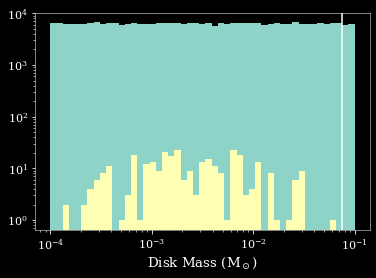

In [88]:
#bins = np.logspace(-3,3)
bins = np.logspace(-4, -1)
pl.hist(pars['disk.mass'], bins=bins)
pl.hist(data['disk.mass'], bins=bins)
pl.axvline(7.6e-2)
pl.loglog()
pl.xlabel("Disk Mass (M$_\odot$)")

## Robitaille grid favors a moderately larger envelope mass (at least for spubhmi)

S4.4 of the paper says M_env = 0.033 Msun within 900 AU and M_env = 0.22 Msun within 10^4 AU

[]

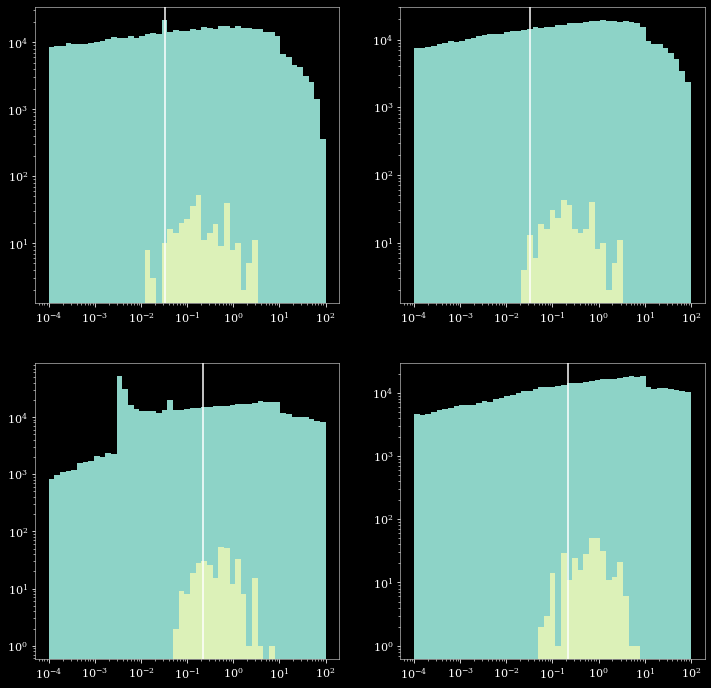

In [87]:
# mass comparisons
pl.figure(figsize=(12,12))
pl.subplot(2,2,1)
bins = np.logspace(-4, 2)
pl.hist(pars['Sphere Masses'][:,5], bins=bins)
pl.hist(data['Sphere Masses'][:,5], bins=bins, alpha=0.7)
pl.axvline(3.3e-2)
pl.loglog()

pl.subplot(2,2,2)
pl.hist(pars['Line-of-Sight Masses'][:,5], bins=bins)
pl.hist(data['Line-of-Sight Masses'][:,5], bins=bins, alpha=0.7)
pl.axvline(3.3e-2)
pl.loglog()

pl.subplot(2,2,3)
pl.hist(pars['Sphere Masses'][:,9], bins=bins)
pl.hist(data['Sphere Masses'][:,9], bins=bins, alpha=0.7)
pl.axvline(0.22)
pl.loglog()

pl.subplot(2,2,4)
pl.hist(pars['Line-of-Sight Masses'][:,9], bins=bins)
pl.hist(data['Line-of-Sight Masses'][:,9], bins=bins, alpha=0.7)
pl.axvline(0.22)
pl.loglog()

[]

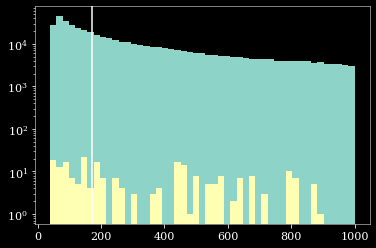

In [39]:
#bins = np.logspace(-3,3)
bins = np.linspace(40, 1000)
pl.hist(pars['disk.rmax'], bins=bins)
pl.hist(data['disk.rmax'], bins=bins)
pl.axvline(172)
pl.semilogy()

[]

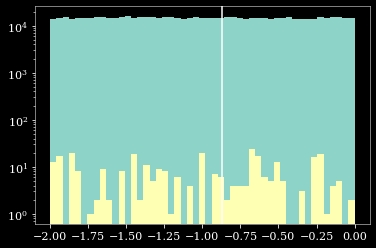

In [44]:
#bins = np.logspace(-3,3)
bins = np.linspace(-2,0)
pl.hist(pars['disk.p'], bins=bins)
pl.hist(data['disk.p'], bins=bins)
pl.axvline(-0.87)
pl.semilogy()

[]

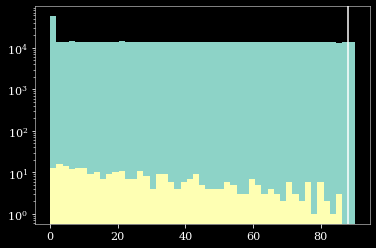

In [46]:
#bins = np.logspace(-3,3)
bins = np.linspace(0,90)
pl.hist(pars['inclination'], bins=bins)
pl.hist(data['inclination'], bins=bins)
pl.axvline(88)
pl.semilogy()

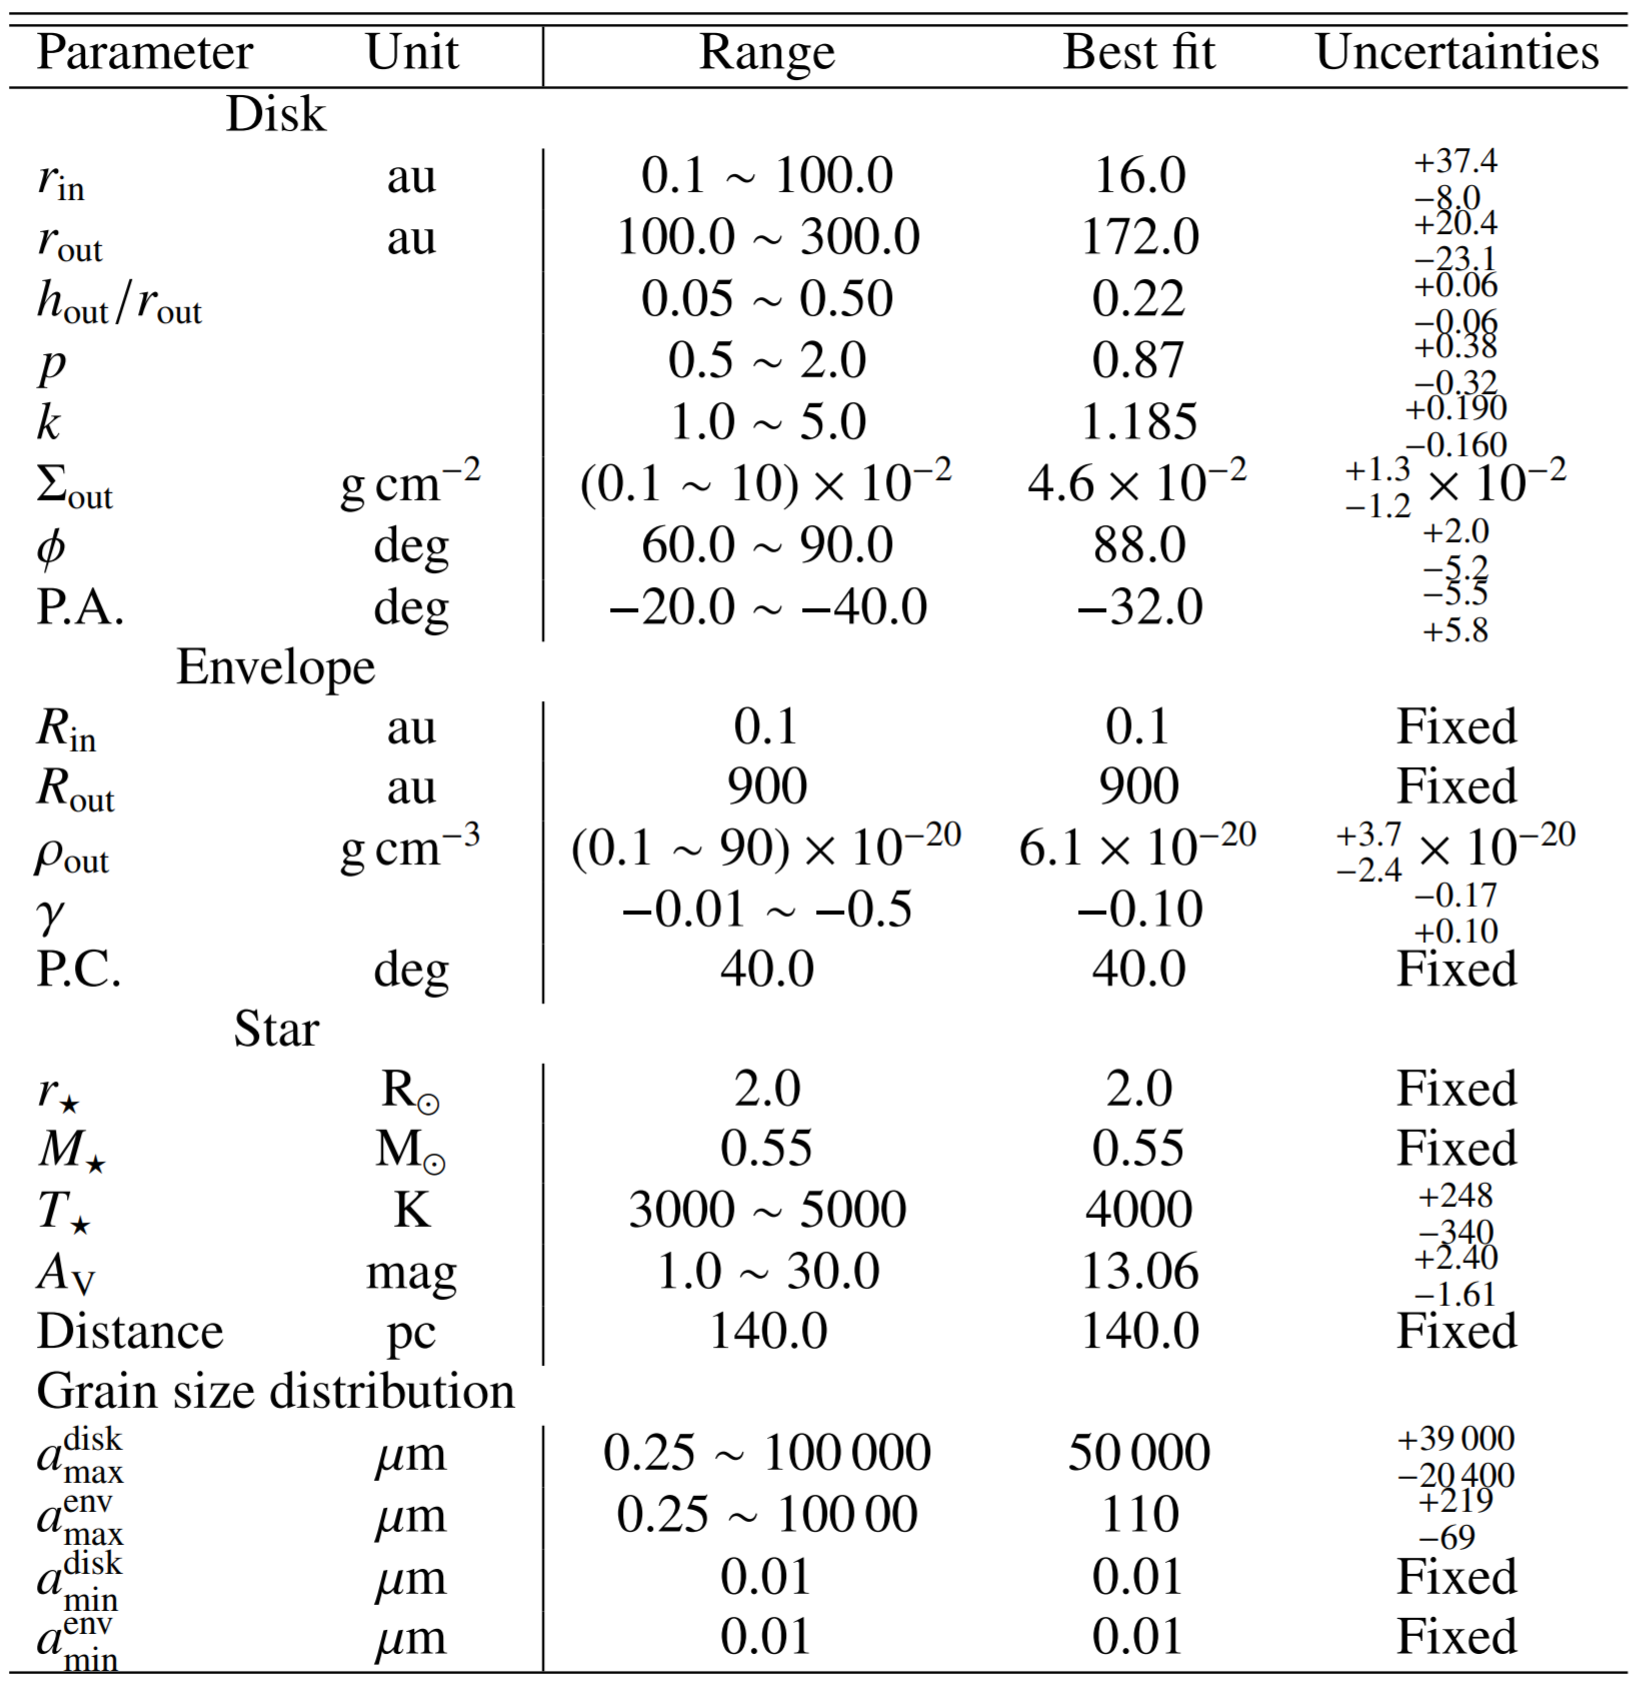

In [30]:
Image('fitpars.png', width=600)